In [4]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [1]:
from spec_tools import Gen_PPF

class Sfh_prior(object):
    def __init__(self, field, galaxy, trials = 5000):

        ppf_dict = {}
        params = ['a', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []

        while idx < trials:
            draw = np.zeros(len(params))

            for i in range(len(draw)):
                draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                
            taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
            masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(draw[0]))
    
            time, sfr, tmax = convert_sfh(get_agebins(draw[0]), masses, maxage = draw[0]*1E9)

        
            T=[0]
            M=[0]
            for i in range(len(time)//2):
                mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                M.append(M[i] + mass)
                T.append(time[i*2+1])

            sfr = sfr/ M[-1] * 10**draw[1] / 1E9
        
            lbt = np.abs(time - time[-1])[::-1]
            lbsfr = sfr[::-1]
        
            sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

            idx +=1
        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])

        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.array(sfr_grid)

In [11]:
df = pd.read_pickle('../dataframes/galaxy_frames/GS_buldge.pkl')

In [27]:
ls ../data/SFH/

0.npy                GND_16883.npy        z1.0_141_imp_84.npy
0_16.npy             GND_16895.npy        z1.0_142_imp.npy
0_84.npy             GND_16903.npy        z1.0_142_imp_16.npy
0_imp.npy            GND_16942.npy        z1.0_142_imp_84.npy
0_imp_16.npy         GND_16945.npy        z1.0_143_imp.npy
0_imp_1D.pkl         GND_17024.npy        z1.0_143_imp_16.npy
0_imp_84.npy         GND_17039.npy        z1.0_143_imp_84.npy
1.npy                GND_17041.npy        z1.0_144_imp.npy
10.npy               GND_17070.npy        z1.0_144_imp_16.npy
100.npy              GND_17098.npy        z1.0_144_imp_84.npy
100_16.npy           GND_17171.npy        z1.0_145_imp.npy
100_84.npy           GND_17194.npy        z1.0_145_imp_16.npy
100_imp.npy          GND_17204.npy        z1.0_145_imp_84.npy
100_imp_16.npy       GND_17211.npy        z1.0_146_imp.npy
100_imp_84.npy       GND_17293.npy        z1.0_146_imp_16.npy
101.npy              GND_17324.npy        z1.0_146_imp_84.npy
101_16.npy           GN

In [25]:
for i in df.index:
    if os.path.isfile('../data/SFH/GSD_{}_1D.pkl'.format(df.id[i])):
        print(df.id[i])

In [15]:
prior = Sfh_prior('GSD', 39170)

FileNotFoundError: [Errno 2] No such file or directory: '../data/SFH/GSD_18201_1D.pkl'

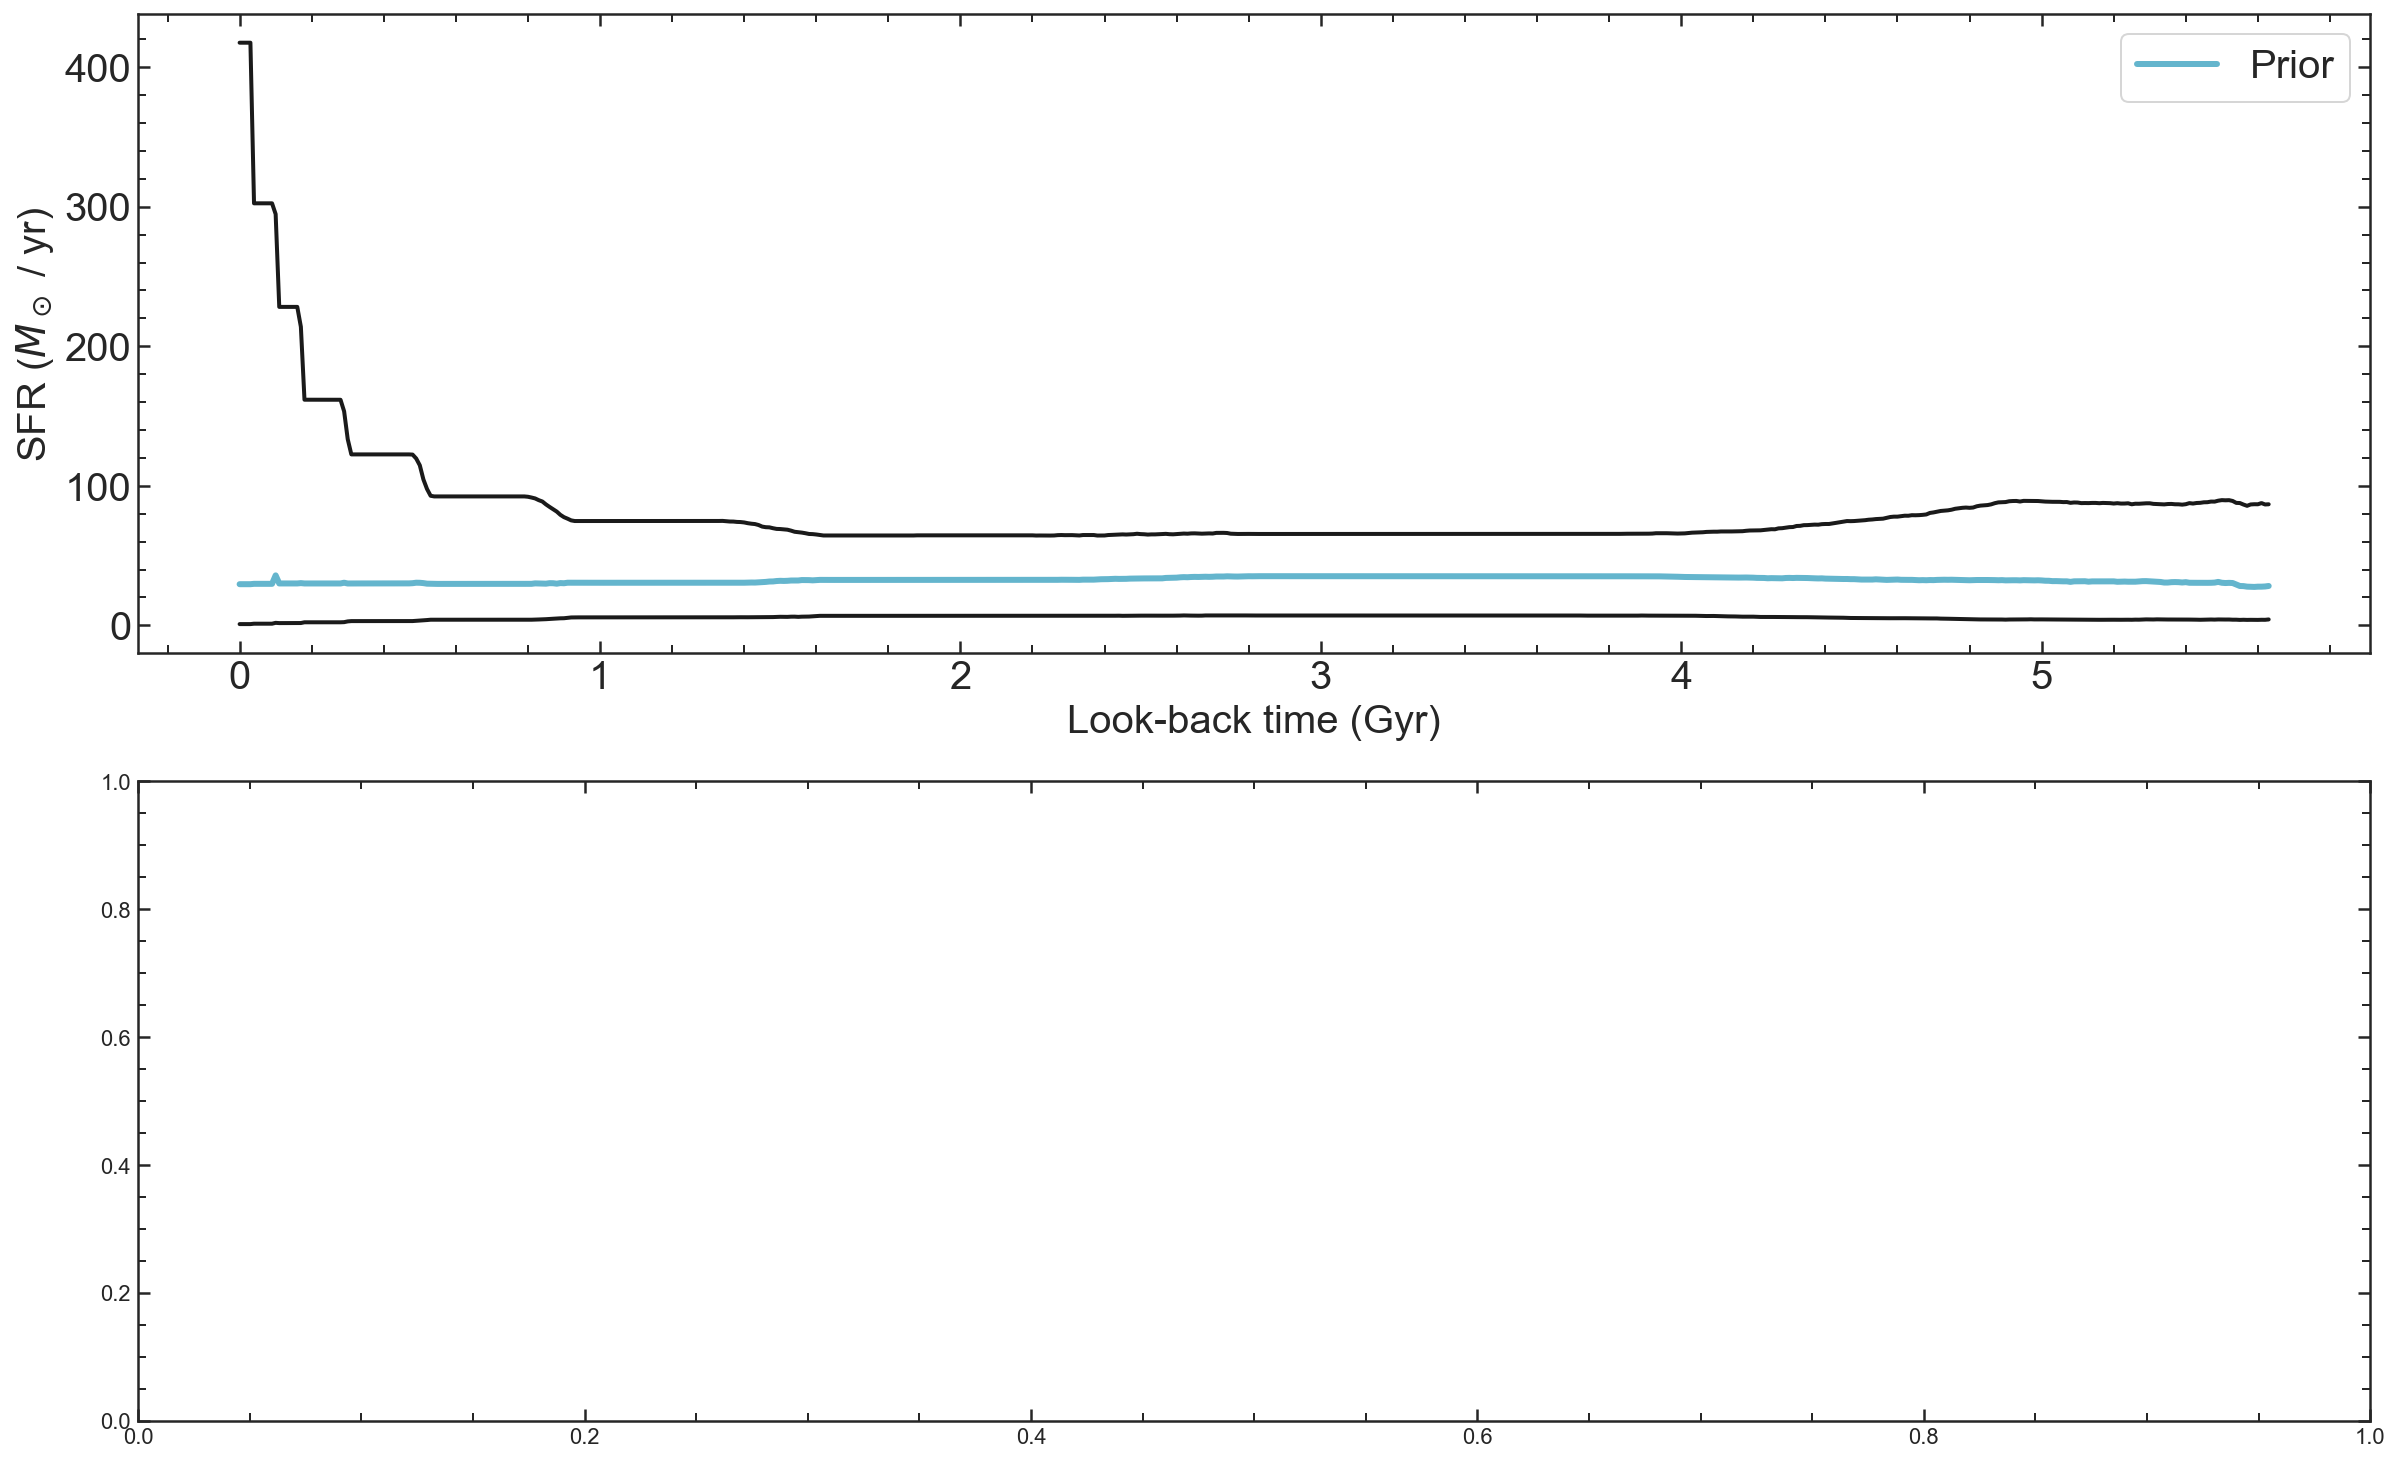

In [17]:
# from bokeh_scripts import RS_img, img_ext
import pickle
from spec_tools import Gen_SFH

galaxies = [18201, 49362]
field = ['GSD', 'GSD']

gs = gridspec.GridSpec(3,1)

plt.figure(figsize =[20,20])

ax = plt.subplot(gs[0])
ax.plot(prior.LBT,prior.SFH, color = 'c', linewidth = 3, zorder = 9, label = 'Prior')
ax.plot(prior.LBT,prior.SFH_16, 'k', linewidth = 2)
ax.plot(prior.LBT,prior.SFH_84, 'k', linewidth = 2)
ax.set_xlabel('Look-back time (Gyr)', fontsize=20)
ax.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=20, frameon = True, loc = 1)


for i in range(2):
    ax = plt.subplot(gs[i+1])

    with open('../data/SFH/{}_{}_1D.pkl'.format(field[i], galaxies[i]), 'rb') as sfh_file:
        sfh = pickle.load(sfh_file)

    isfh = interp1d(sfh.LBT,sfh.SFH)  
    isfhl = interp1d(sfh.LBT,sfh.SFH_16)       
    isfhh = interp1d(sfh.LBT,sfh.SFH_84)       

    for xx in range(1000):           
        ax.plot(sfh.fulltimes, sfh.sfr_grid[xx], color = '#532436', alpha=.075, linewidth = 0.5)
    ax.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9, label = '{0}-{1}'.format(field[ID], galaxies[ID]))
    ax.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
    ax.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

